# Part 2 - Other features analysis

## ..

In [31]:
#pip install matplotlib

In [1]:
# Import packages
import json
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### *100m sprint*

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = "https://worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior"

# Send a request to fetch the page content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Parse the page content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the data
table = soup.find('table')

# Extract table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extract table rows
rows = []
for row in table.find_all('tr')[1:]:  # Skip the header row
    columns = row.find_all('td')
    row_data = [col.text.strip() for col in columns]
    rows.append(row_data)

# Create a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Save the data to a CSV file
df.to_csv('100m_sprint_all_time_toplist.csv', index=False)

print("Data has been saved to 100m_sprint_all_time_toplist.csv")


Data has been saved to 100m_sprint_all_time_toplist.csv


In [2]:
df

,Rank,Mark,WIND,Competitor,DOB,Nat,Pos,,Venue,Date,Results Score
0,1,9.58,+0.9,Usain BOLT,21 AUG 1986,JAM,1,,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356
1,2,9.69,+2.0,Tyson GAY,09 AUG 1982,USA,1,,Shanghai (CHN),20 SEP 2009,1316
2,2,9.69,-0.1,Yohan BLAKE,26 DEC 1989,JAM,1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",23 AUG 2012,1316
3,4,9.72,+0.2,Asafa POWELL,23 NOV 1982,JAM,1f1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",02 SEP 2008,1305
4,5,9.74,+0.9,Justin GATLIN,10 FEB 1982,USA,1,,"Suhaim bin Hamad Stadium, Doha (QAT)",15 MAY 2015,1298
...,...,...,...,...,...,...,...,...,...,...,...
95,95,9.94,-0.2,Bernard WILLIAMS,19 JAN 1978,USA,2,,"Commonwealth Stadium, Edmonton (CAN)",05 AUG 2001,1228
96,95,9.94,+1.7,Diondre BATSON,13 JUL 1992,USA,2h2,,"Hayward Field, Eugene, OR (USA)",25 JUN 2015,1227
97,95,9.94,+1.4,Andrew FISHER,15 DEC 1991,JAM,2,,"Moratalaz, Madrid (ESP)",11 JUL 2015,1227
98,95,9.94,+1.0,Ameer WEBB,19 MAR 1991,USA,2f1,,"Stadio Olimpico, Roma (ITA)",02 JUN 2016,1227


We now have created a dataframe and saved it in a csv file. This gives us informations about the 100 first athletes for the 100m sprint in the world.

We have 11 columns:
- ID
- Rank
- Mark
- WIND
- Competitor (the name and surname of the athlete)
- DOB (the date of birth)
- NAT (nationality)
- Pos (I don't know yet)
- Venue (The venue in which he made his best time)
- Date (the date he made his best time)
- Result score

We ideally want to have more information about each individual athlete. To do that, another page of this website has access to their profile page. We need to get access to it doing once again webscrapping.

In [5]:
#pip install requests

## Data collection

Web scrapping with *beautifulsoup4* from the website https://worldathletics.org/world-rankings/5000m/men?regionType=world&page=1&rankDate=2024-06-04&limitByCountry=0

#### *5000m*

In [2]:
#pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


Import packages

Create and define functions

In [3]:
# Function to fetch athlete profile URLs and nationalities
def fetch_profile_urls():
    url = "https://worldathletics.org/world-rankings/5000m/men?regionType=world&page=1&rankDate=2024-06-04&limitByCountry=0"
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all table rows containing athlete data
    athlete_rows = soup.find_all('tr', class_='table-row--hover')

    athletes = {}
    for row in athlete_rows:
        name_element = row.find('td', {'data-th': 'Competitor'})
        if name_element:
            name = name_element.text.strip()
            profile_url = "https://worldathletics.org" + row['data-athlete-url']
            nationality_element = row.find('td', {'data-th': 'Nat'})
            if nationality_element:
                nationality = nationality_element.text.strip()
            else:
                nationality = ""
            athletes[name] = {'profile_url': profile_url, 'nationality': nationality}

    return athletes

In [4]:
# Function to recursively search for 5000 meters results
def search_5000m_results(node, results):
    if isinstance(node, dict):
        for key, value in node.items():
            if isinstance(value, list) or isinstance(value, dict):
                search_5000m_results(value, results)
            elif key == 'discipline' and '5000 Metres' in value:
                results.append(node)
    elif isinstance(node, list):
        for item in node:
            if isinstance(item, list) or isinstance(item, dict):
                search_5000m_results(item, results)


# Function to extract 5000m results for a given athlete URL
def extract_5000m_results(url):
    # Fetch the HTML content of the page
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    html_content = response.text

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the <script> tag with id="__NEXT_DATA__" and type="application/json"
    script_tag = soup.find('script', {'id': '__NEXT_DATA__', 'type': 'application/json'})

    # Extract the JSON content from the <script> tag
    json_content = script_tag.string

    # Parse the JSON content
    data = json.loads(json_content)

    # Extract 5000 meters results
    results_5000m = []
    search_5000m_results(data, results_5000m)

    return results_5000m


In [5]:
# Function to extract relevant data
def extract_5000m_data(athlete, nationality, results):
    for result in results:
        # Check if this is a progression result with multiple results
        if 'results' in result:
            for progression in result['results']:
                rows.append({
                    'Athlete': athlete,
                    'Nationality': nationality,
                    'Score': progression.get('resultScore', ''),
                    'Date': progression.get('date', ''),
                    'Venue': progression.get('venue', ''),
                    'Place': progression.get('place', '')  # Use 'listPosition' instead of 'place'
                })
        else:
            rows.append({
                'Athlete': athlete,
                'Nationality': nationality,
                'Score': result.get('resultScore', ''),
                'Date': result.get('date', ''),
                'Venue': result.get('venue', ''),
                'Place': result.get('place', '')  # Use 'listPosition' instead of 'place'
            })

Create a dataset in a data frame and csv format.

In [6]:
# Fetch athlete profile URLs
athletes = fetch_profile_urls()

# List to hold all extracted rows
all_rows = []

# Loop through each athlete and extract their 5000m results
for athlete, data in athletes.items():
    athlete_url = data['profile_url']
    nationality = data['nationality']
    #print(f"Extracting 5000m results for {athlete}...")
    athlete_results = extract_5000m_results(athlete_url)
    
    # List to hold the extracted rows for this athlete
    rows = []
    # Extract data for this athlete
    extract_5000m_data(athlete, nationality, athlete_results)
    # Add rows for this athlete to the list of all rows
    all_rows.extend(rows)

# Define CSV file name
csv_file_name = '5000m_results_with_urls.csv'

# Write all rows to CSV
with open(csv_file_name, 'w', newline='') as csv_file:
    fieldnames = ['Athlete', 'Nationality', 'Score', 'Date', 'Venue', 'Place']  # Add 'Athlete' field
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for row in all_rows:
        writer.writerow(row)

print(f"Data successfully written to {csv_file_name}")

KeyboardInterrupt: 

## Preprocessing the data

### Put the right type of attribute to each variable 

In [2]:
df_5000m = pd.read_csv("5000m_results_with_urls.csv")
print(df_5000m.head())
print(df_5000m.info())

          Athlete Nationality   Score         Date  \
0  Yomif KEJELCHA         ETH  1288.0  30 MAY 2024   
1  Yomif KEJELCHA         ETH  1288.0  30 MAY 2024   
2  Yomif KEJELCHA         ETH  1119.0  25 JUL 2014   
3  Yomif KEJELCHA         ETH  1232.0  11 SEP 2015   
4  Yomif KEJELCHA         ETH  1198.0  14 MAY 2016   

                               Venue  Place  
0        Bislett Stadion, Oslo (NOR)    NaN  
1        Bislett Stadion, Oslo (NOR)    NaN  
2    Hayward Field, Eugene, OR (USA)    NaN  
3  Boudewijnstadion, Bruxelles (BEL)    NaN  
4   Shanghai Stadium, Shanghai (CHN)    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlete      3982 non-null   object 
 1   Nationality  3982 non-null   object 
 2   Score        1645 non-null   float64
 3   Date         2875 non-null   object 
 4   Venue        2875 non-null   object 

In [3]:
# Counting null values per column
null_counts = df_5000m.isnull().sum()
print("Number of null values per column:")
print(null_counts)

Number of null values per column:
Athlete           0
Nationality       0
Score          2337
Date           1107
Venue          1107
Place          2514
dtype: int64


In [4]:
# Removing rows with null 'Venue' & removing duplicates
df_5000m_cleaned0 = df_5000m.dropna(subset=['Venue'])
df_5000m_cleaned1 = df_5000m_cleaned0.drop_duplicates()
df_5000m_cleaned2 = df_5000m_cleaned1.dropna(subset=['Place', 'Score'], how='all')

In [5]:
null_counts = df_5000m_cleaned2.isnull().sum()
print("Number of null values per column:")
print(null_counts)

Number of null values per column:
Athlete          0
Nationality      0
Score          477
Date             0
Venue            0
Place          796
dtype: int64


Now that we have removed all of the rows with NA venue, and all of the rows where either `place`, `score` or both were empty, we need to assign the right type for each variable.

The 5 differents variables are: 
- Athlete: object into character or factor
- Score: float
- Data: object to convert into datetime
- Venue: object into character or factor or to dertermine
- Place: float to convert into nummerical

In [6]:
df = df_5000m_cleaned2
df.loc[:, 'Athlete'] = pd.Categorical(df['Athlete'])
df.loc[:, 'Nationality'] = pd.Categorical(df['Nationality'])
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%d %b %Y', errors='coerce')
print(df.head())
print(df.info())

          Athlete Nationality   Score                 Date  \
0  Yomif KEJELCHA         ETH  1288.0  2024-05-30 00:00:00   
2  Yomif KEJELCHA         ETH  1119.0  2014-07-25 00:00:00   
3  Yomif KEJELCHA         ETH  1232.0  2015-09-11 00:00:00   
4  Yomif KEJELCHA         ETH  1198.0  2016-05-14 00:00:00   
5  Yomif KEJELCHA         ETH  1205.0  2017-05-27 00:00:00   

                               Venue  Place  
0        Bislett Stadion, Oslo (NOR)    NaN  
2    Hayward Field, Eugene, OR (USA)    NaN  
3  Boudewijnstadion, Bruxelles (BEL)    NaN  
4   Shanghai Stadium, Shanghai (CHN)    NaN  
5    Hayward Field, Eugene, OR (USA)    NaN  
<class 'pandas.core.frame.DataFrame'>
Index: 1533 entries, 0 to 3967
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlete      1533 non-null   object 
 1   Nationality  1533 non-null   object 
 2   Score        1056 non-null   float64
 3   Date         1533 non-null   object

### Data simulation

In [7]:
# Define factors for distance from France, climate similarity, and cultural/travel ease for each country
distance_factor = {
    'ETH': 0.5, 'USA': 0.7, 'AUS': 0.9, 'NOR': 0.2, 'GER': 0.1, 'FRA': 0.0, 
    'KEN': 0.5, 'ESP': 0.1, 'GBR': 0.1, 'CAN': 0.6, 'UGA': 0.5, 'SUI': 0.1, 
    'BEL': 0.1, 'JPN': 0.8, 'NED': 0.1, 'IRL': 0.2, 'SWE': 0.2, 'BRN': 0.7, 
    'ITA': 0.1, 'RUS': 0.4, 'GUA': 0.8, 'BDI': 0.5, 'SRB': 0.3, 'RSA': 0.6, 
    'THA': 0.8, 'ERI': 0.5, 'AUT': 0.1, 'DJI': 0.6, 'IND': 0.7, 'URU': 0.8, 'MAR': 0.2
}

climate_factor = {
    'ETH': 0.4, 'USA': 0.6, 'AUS': 0.6, 'NOR': 0.7, 'GER': 0.9, 'FRA': 1.0, 
    'KEN': 0.4, 'ESP': 0.8, 'GBR': 0.8, 'CAN': 0.6, 'UGA': 0.4, 'SUI': 0.9, 
    'BEL': 0.8, 'JPN': 0.6, 'NED': 0.8, 'IRL': 0.8, 'SWE': 0.7, 'BRN': 0.4, 
    'ITA': 0.9, 'RUS': 0.6, 'GUA': 0.3, 'BDI': 0.4, 'SRB': 0.7, 'RSA': 0.5, 
    'THA': 0.3, 'ERI': 0.4, 'AUT': 0.9, 'DJI': 0.4, 'IND': 0.4, 'URU': 0.4, 'MAR': 0.8
}

cultural_factor = {
    'ETH': 0.4, 'USA': 0.7, 'AUS': 0.6, 'NOR': 0.8, 'GER': 0.9, 'FRA': 1.0, 
    'KEN': 0.4, 'ESP': 0.9, 'GBR': 0.9, 'CAN': 0.7, 'UGA': 0.4, 'SUI': 0.9, 
    'BEL': 0.9, 'JPN': 0.6, 'NED': 0.9, 'IRL': 0.8, 'SWE': 0.8, 'BRN': 0.4, 
    'ITA': 0.9, 'RUS': 0.6, 'GUA': 0.3, 'BDI': 0.4, 'SRB': 0.7, 'RSA': 0.4, 
    'THA': 0.3, 'ERI': 0.4, 'AUT': 0.9, 'DJI': 0.3, 'IND': 0.3, 'URU': 0.3, 'MAR': 0.8
}

# Define initial count of athletes per nationality
initial_nationalities = {
    'ETH': 0, 'USA': 0, 'AUS': 0, 'NOR': 0, 'GER': 0, 'FRA': 0, 
    'KEN': 0, 'ESP': 0, 'GBR': 0, 'CAN': 0, 'UGA': 0, 'SUI': 0, 
    'BEL': 0, 'JPN': 0, 'NED': 0, 'IRL': 0, 'SWE': 0, 'BRN': 0, 
    'ITA': 0, 'RUS': 0, 'GUA': 0, 'BDI': 0, 'SRB': 0, 'RSA': 0, 
    'THA': 0, 'ERI': 0, 'AUT': 0, 'DJI': 0, 'IND': 0, 'URU': 0, 'MAR': 0
}

In [8]:
# Define the number of simulations
num_simulations = 10000

# Count the number of athletes per nationality
nationalities = df['Nationality'].value_counts().to_dict()

# Function to calculate mean and standard deviation based on factors
def calculate_params(distance, climate, cultural):
    base_mean = 0.10
    base_std = 0.05
    mean_cheering_effect = base_mean + 0.05 * (1 - distance) + 0.05 * cultural
    std_cheering_effect = base_std - 0.01 * cultural
    
    mean_environmental_adaptation = base_mean + 0.05 * climate
    std_environmental_adaptation = base_std - 0.01 * climate
    
    return mean_cheering_effect, std_cheering_effect, mean_environmental_adaptation, std_environmental_adaptation

# Create the params dictionary
params = {}
for nationality in nationalities.keys():
    mean_cheering_effect, std_cheering_effect, mean_environmental_adaptation, std_environmental_adaptation = calculate_params(
        distance_factor.get(nationality, 0), climate_factor.get(nationality, 0), cultural_factor.get(nationality, 0)
    )
    params[nationality] = {
        'mean_cheering_effect': mean_cheering_effect, 'std_cheering_effect': std_cheering_effect,
        'mean_environmental_adaptation': mean_environmental_adaptation, 'std_environmental_adaptation': std_environmental_adaptation
    }

    
# Function to simulate performance for a given nationality
def simulate_performance(nationality, num_athletes):
    mean_cheering_effect = params[nationality]['mean_cheering_effect']
    std_cheering_effect = params[nationality]['std_cheering_effect']
    mean_environmental_adaptation = params[nationality]['mean_environmental_adaptation']
    std_environmental_adaptation = params[nationality]['std_environmental_adaptation']
    
    cheering_effect = np.random.normal(mean_cheering_effect, std_cheering_effect, num_athletes)
    environmental_adaptation = np.random.normal(mean_environmental_adaptation, std_environmental_adaptation, num_athletes)
    
    return cheering_effect, environmental_adaptation

# Initialize lists to store simulated results
cheering_effects = []
environmental_adaptations = []

# Iterate through each unique nationality in the DataFrame
for nationality in df['Nationality'].unique():
    if nationality in nationalities:
        num_athletes = nationalities[nationality]  # Number of athletes for this nationality
        cheering_effect, environmental_adaptation = simulate_performance(nationality, num_athletes)
        
        # Extend lists with simulation results
        cheering_effects.extend(cheering_effect)
        environmental_adaptations.extend(environmental_adaptation)
    else:
        # Handle cases where nationality in df['Nationality'] is not found in nationalities
        print(f"Warning: No athlete count found for nationality '{nationality}'")


In [11]:
# Assign simulated results to DataFrame using .loc to avoid SettingWithCopyWarning
df.loc[:, 'CrowdCheeringEffect'] = cheering_effects[:len(df)]  # Ensure lengths match
df.loc[:, 'EnvironmentalAdaptation'] = environmental_adaptations[:len(df)]  # Ensure lengths match
df.head()

,Athlete,Nationality,Score,Date,Venue,Place,CrowdCheeringEffect,EnvironmentalAdaptation
0,Yomif KEJELCHA,ETH,1288.0,2024-05-30 00:00:00,"Bislett Stadion, Oslo (NOR)",NaN,0.117087,0.129918
2,Yomif KEJELCHA,ETH,1119.0,2014-07-25 00:00:00,"Hayward Field, Eugene, OR (USA)",NaN,0.148995,0.137654
3,Yomif KEJELCHA,ETH,1232.0,2015-09-11 00:00:00,"Boudewijnstadion, Bruxelles (BEL)",NaN,0.191238,0.095889
4,Yomif KEJELCHA,ETH,1198.0,2016-05-14 00:00:00,"Shanghai Stadium, Shanghai (CHN)",NaN,0.189600,0.113813
5,Yomif KEJELCHA,ETH,1205.0,2017-05-27 00:00:00,"Hayward Field, Eugene, OR (USA)",NaN,0.056305,0.130853


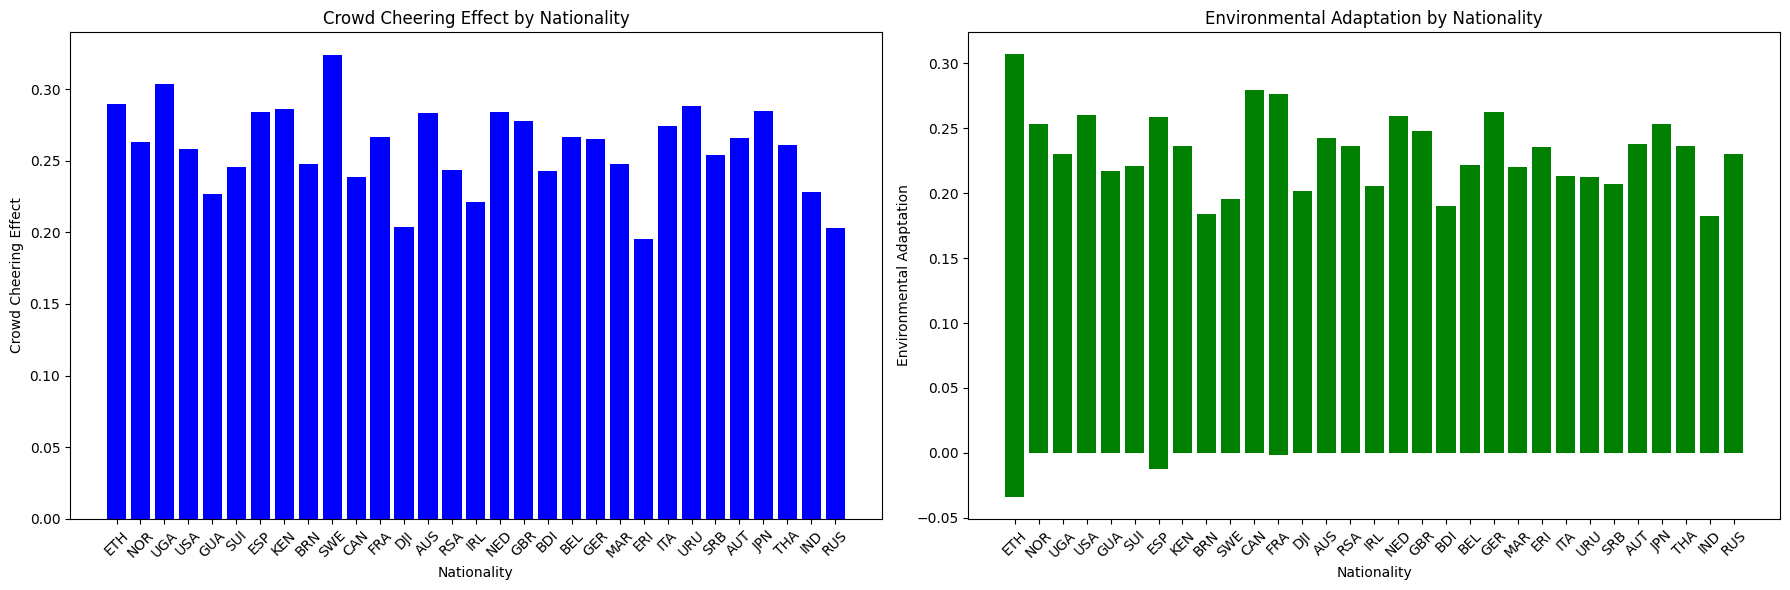

In [12]:
# Set up subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Crowd Cheering Effect by Nationality
axs[0].bar(df['Nationality'], df['CrowdCheeringEffect'], color='blue')
axs[0].set_xlabel('Nationality')
axs[0].set_ylabel('Crowd Cheering Effect')
axs[0].set_title('Crowd Cheering Effect by Nationality')
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Environmental Adaptation by Nationality
axs[1].bar(df['Nationality'], df['EnvironmentalAdaptation'], color='green')
axs[1].set_xlabel('Nationality')
axs[1].set_ylabel('Environmental Adaptation')
axs[1].set_title('Environmental Adaptation by Nationality')
axs[1].tick_params(axis='x', rotation=45)
# Adjust layout
plt.tight_layout()
plt.show()

### Normalise / Standardise nummerical features